# Barycentric Lagrange Interpolation

This rewriting of the Lagrange interpolation goes back at least seventy-five years but was popularized by [Berrut and Trefethen](https://epubs.siam.org/doi/pdf/10.1137/S0036144502417715) in the early 21st century.  The idea here is basically to rewrite the Lagrange form to avoid the problems mentioned above.

First define

$$\mathcal{l}(x)\equiv \prod_{i=0}^n (x-x_i).$$

Then note that

$$L_j^n(x) = \frac{\mathcal{l}(x)}{(x-x_j)} w_j,$$

where the barycentric weight $w_j$ is  

$$ w_j \equiv \frac{1}{\prod_{i=0,i\neq j}^n (x_j-x_i)}.$$

Our interpolating polynomial now becomes

$$p_n(x) = \sum_{i=0}^n L_i^n(x) f(x_i) =  \mathcal{l}(x)\sum_{i=0}^n \frac{w_i}{x-x_i} f(x_i).$$

This is called the *first form of barycentric interpolation*.  Once we have computed the weights $w_j$, evaluation of $p_n(x)$ now requires $\mathcal{O}(n)$ flops thus removing the first objection to the Lagrange form of the interpolating polynomial.

If we add a new node $x_{n+1}$, we can construct new weights $w_j$ by dividing the old weights by $(x_j-x_{n+1})$ to get the new $w_j$ (plus computing $w_{n+1}$ using the original formula).  This effectively eliminates the second objection to the Lagrange form of the intepolating polynomial.

There is another similification we can use before constructing an algorithm for interpolation.  Note that for the function $g(x)\equiv 1$,

$$
\begin{align}
g(x) &=  \mathcal{l}(x)\sum_{i=0}^n \frac{w_i}{x-x_i} g(x_i),\\
 &= \mathcal{l}(x)\sum_{i=0}^n \frac{w_i}{x-x_i}.
\end{align}
$$
As we shall see when we discuss interpolation errors, this formula is actually exact.  As a result,

$$
\begin{align}
p_n(x) &= \frac{p_n(x)}{1} = \frac{p_n(x)}{g(x)},\\
 &=\frac{\mathcal{l}(x)\sum_{i=0}^n \frac{w_i}{x-x_i} f(x_i)}{\mathcal{l}(x)\sum_{i=0}^n \frac{w_i}{x-x_i}},
\end{align}
$$

which simiplifies to the second, or *true form of barycentric interpolation*

$$p_n(x)=\frac{\sum_{i=0}^n \frac{w_i}{x-x_i} f(x_i)}{\sum_{i=0}^n \frac{w_i}{x-x_i}}.$$  

In this form, we avoid evaluating $\mathcal{l}(x)$ entirely and the sum in the numerator and denominator can easily be constructed simultaneously.

Note that there are two stages to implementation of barycentric Lagrange interpolation: i) computing the weights and ii) computing the interpolation at the desired points.  The first should be done *only once* whereas the second needs to be done at each point where the interpolation is computed.  A python code to do this is given below. 

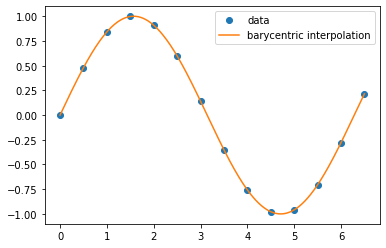

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def baryweight(x):
    # build the weights recursively by effectively adding new points one at a time
    w = [1.]*len(x)
    for i in range(0,len(x)):
        # in iteration i we compute w[i] from scratch while
        # including the contribution of x[i] to the other weights
        for j in range(0,i):
            w[j]=(x[j]-x[i])*w[j]
            w[i]=(x[i]-x[j])*w[i]
    # do the divisions at the end to minimize the total number of divisions
    return [1/x for x in w]

def baryinterp(w,x,y,xp):
    # Compute the barycentric interpolation at xp given the observed data in lists
    # x and y and the precomputed weights in a list w
    numer=0.
    denom=0.
    for i in range(0,len(x)):
        xdiff=xp-x[i]
        # We first check to ensure we are not actually evaluated at a given data point.
        # (This would lead to division by zero which would cause problems).
        if (xdiff == 0):
            return y[i]
        else:
            tmp=w[i]/xdiff
            numer += tmp*y[i]
            denom += tmp
    return numer/denom

# Main program showing functions defined above used to interpolate data taken from
# a simple sine function

# This creates a list of x values for our observed data
dx = 0.5
x_data = np.arange(0, 6.5+dx, dx)

# Compute the weights for the interpolating polynomial.  
weights=baryweight(x_data)

# Create a list of y values for our observed data and plot
# our observations
y_data = np.sin(x_data)
plt.plot(x_data, y_data, "o", label="data")

# Now we want to fill in between our observed data points using
# a barycentric Lagrange interpolation and plot the result
dx = 0.01
x_all = np.arange(0,6.5+dx,dx)
y_all = [0]*len(x_all)
for i in range(0,len(x_all)):
    y_all[i] = baryinterp(weights,x_data,y_data,x_all[i])
    
plt.plot(x_all, y_all, label="barycentric interpolation")
plt.legend()
plt.show()

There are a few things to note here:

- the weights depend only on the $x_i$ and not on $f(x_i)$.  As such, the same weights could be used in the interpolation of any function whose values are known at the same set of $x_i$  (i.e. we can resuse the weights for other functions).
- the order of the nodes does not matter.  This means that if we want to add a new data point, it can just be appended to the end of the list, it does not need to be inserted in order.
- if you want to add a new data point, you could easily write another function (say "addpoint") to update the weights.  It would essentially consist of the "extra" iteration of the loop in the above `baryweight` function, accounting for the fact that we have already done the `1/x` operation.  It should be clear that the update is $\mathcal{O}(n)$ operation as only the inner loop is computed.
- you may have noticed that the `baryinterp` function dealt with the case where $x=x_i$ as a special case to avoid division by zero.  You might be concerned about overflow in the situation where $x$ is close to $x_i$ but not exactly the same.  There are ways of dealing with this when it arises, but it turns out it is not a serious concern for most practical applications of interpolation.
- as with any algorithm, one should ask if this is numerically stable.  As we emphasized when we discussed errors in scientific computing, it is only reasonable to ask if the algorithm is stable when applied to a well-conditioned problem.  As we will discuss shortly, polynomial interpolation for large numbers of points is only stable if these points are chosen appropriately.  In this case, [Higham](https://www.maths.manchester.ac.uk/~higham/narep/narep440.pdf) has shown that barycentric Lagrange interpolation is unconditionally stable (the first form is slightly better than the "true" form in this regards, but the difference for practical purposes is not usually significant).
- for some node spacings, it is possible to give an explicit formula for the barycentric weights $w_j$.  As these weights appear in the true form of the barycentric interpolation in both the numerator and denominator, any common factor in all the weights can be cancelled without affecting the result. 

There are also built in versions of [barycentric interpolation in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.barycentric_interpolate.html#scipy.interpolate.barycentric_interpolate). The SciPy version also has functions to add new nodes and new, or different, values of the function to be interpolated (making use of the previously computed weights in both cases).